In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import pandas_datareader.data as reader
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

ls_ret = pd.read_pickle("long_short_returns.pkl")
momentum = pd.read_csv("Data/F-F_Momentum_Factor.csv", index_col='Date')

In [20]:
end_date = dt.date(2018, 6, 30)
start_date = dt.date(1961, 6, 30)
returns = pd.DataFrame(ls_ret)
returns.index = returns.index.rename("Date")
returns

,long_short_ret
Date,
1961-07,0.002731
1961-08,-0.012334
1961-09,0.001667
1961-10,0.005878
1961-11,0.009695
...,...
2018-02,-0.001483
2018-03,0.018226
2018-04,0.011251


In [18]:
momentum.index = pd.to_datetime(momentum.index.astype(str), format='%Y%m')
momentum.tail()

,Mom
Date,
2024-12-01,-0.30
2025-01-01,0.95
2025-02-01,-0.82
2025-03-01,-2.82
2025-04-01,4.94


In [21]:
factors = reader.DataReader("F-F_Research_Data_Factors", "famafrench", start_date, end_date)[0]
factors = factors[1:]

/var/folders/47/ztkg05vx2hbdgfnfn0bh1y3w0000gn/T/ipykernel_36990/3560683651.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factors = reader.DataReader("F-F_Research_Data_Factors", "famafrench", start_date, end_date)[0]
/var/folders/47/ztkg05vx2hbdgfnfn0bh1y3w0000gn/T/ipykernel_36990/3560683651.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factors = reader.DataReader("F-F_Research_Data_Factors", "famafrench", start_date, end_date)[0]


In [46]:
df = pd.merge(returns, factors, on="Date")
df = pd.merge(df, momentum, on="Date")
df[["Mkt-RF", "SMB", "HML", "RF", "Mom"]] = df[["Mkt-RF", "SMB", "HML", "RF", "Mom"]]/100
df["LS-RF"] = df.long_short_ret - df.RF
RF = factors['RF']
pd.to_pickle(RF, "RF.pkl")
df

,long_short_ret,Mkt-RF,SMB,HML,RF,Mom,LS-RF
Date,,,,,,,


In [52]:
#Fama-French 3 Factor Model
Y = df["LS-RF"]
X = df[["Mkt-RF", 'SMB', 'HML']]
X_sm = sm.add_constant(X)

ols_model = sm.OLS(Y, X).fit(cov_type="HC3")
ols_residuals = ols_model.resid

resid_sq = ols_residuals ** 2 #Squared residuals
var_model = sm.OLS(resid_sq, X).fit(cov_type="HC3") #estimating the residuals
sigma2_hat = var_model.fittedvalues.clip(lower=1e-8) #avoiding 0

sigma = np.diag(sigma2_hat) #constructing Covariance Matrix


model = sm.GLS(Y, X_sm, sigma=sigma)
results = model.fit(cov_type='HAC', cov_kwds={'maxlags': 4})
residuals = results.resid

print(results.summary())
from statsmodels.iolib.summary2 import summary_col

# Use summary_col to combine models or present a single model
latex_summary = summary_col([results], stars=True, float_format="%.4f").as_latex()
print(latex_summary)


                            GLS Regression Results                            
Dep. Variable:                  LS-RF   R-squared:                       0.561
Model:                            GLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     81.70
Date:                Wed, 11 Jun 2025   Prob (F-statistic):           3.83e-45
Time:                        16:22:28   Log-Likelihood:                 476.78
No. Observations:                 684   AIC:                            -945.6
Df Residuals:                     680   BIC:                            -927.4
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.001     -0.198      0.8

0.8435830500065528

Feature Importances:
SMB       0.814739
Mkt-RF    0.181470
Mom       0.002338
HML       0.001453
dtype: float64


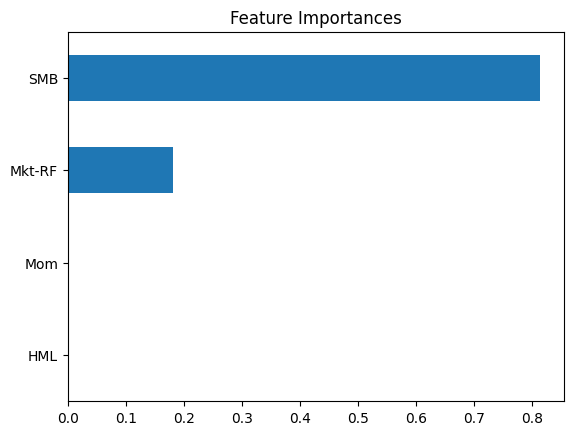

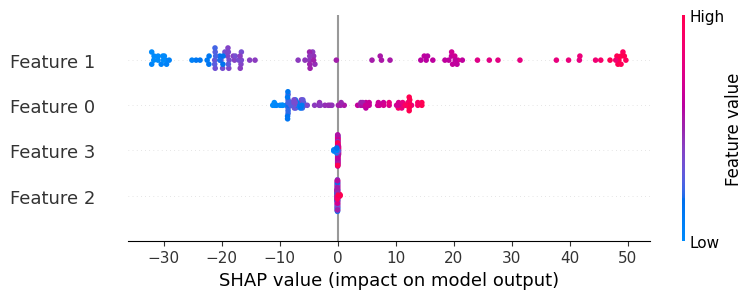

[[ 1.76405235  0.40015721  0.97873798  2.2408932 ]
 [ 1.86755799 -0.97727788  0.95008842 -0.15135721]
 [-0.10321885  0.4105985   0.14404357  1.45427351]
 [ 0.76103773  0.12167502  0.44386323  0.33367433]
 [ 1.49407907 -0.20515826  0.3130677  -0.85409574]
 [-2.55298982  0.6536186   0.8644362  -0.74216502]
 [ 2.26975462 -1.45436567  0.04575852 -0.18718385]
 [ 1.53277921  1.46935877  0.15494743  0.37816252]
 [-0.88778575 -1.98079647 -0.34791215  0.15634897]
 [ 1.23029068  1.20237985 -0.38732682 -0.30230275]
 [-1.04855297 -1.42001794 -1.70627019  1.9507754 ]
 [-0.50965218 -0.4380743  -1.25279536  0.77749036]
 [-1.61389785 -0.21274028 -0.89546656  0.3869025 ]
 [-0.51080514 -1.18063218 -0.02818223  0.42833187]
 [ 0.06651722  0.3024719  -0.63432209 -0.36274117]
 [-0.67246045 -0.35955316 -0.81314628 -1.7262826 ]
 [ 0.17742614 -0.40178094 -1.63019835  0.46278226]
 [-0.90729836  0.0519454   0.72909056  0.12898291]
 [ 1.13940068 -1.23482582  0.40234164 -0.68481009]
 [-0.87079715 -0.57884966 -0.31

In [38]:
#Random Forest Regression - FFC

from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import shap

X = df[["Mkt-RF", 'SMB', 'HML', 'Mom']]
Y = df['LS-RF']

X, Y = make_regression(n_features=4, n_informative=2, random_state=0, shuffle=False)
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X, Y)
print(regr.score(X, Y))

feature_names = ['Mkt-RF', 'SMB', 'HML', 'Mom']
importances = pd.Series(regr.feature_importances_, index=feature_names)
importances = importances.sort_values(ascending=False)

print("\nFeature Importances:")
print(importances)

# Plot
importances.plot(kind='barh', title='Feature Importances')
plt.gca().invert_yaxis()
plt.show()



explainer = shap.Explainer(regr, X)
shap_values = explainer(X)

# Summary plot of global feature effects
shap.summary_plot(shap_values, X)

print(X)

In [42]:
#FFC - OLS
import statsmodels.api as sm

X = df[["Mkt-RF", 'SMB', 'HML', 'Mom']]
Y = df['LS-RF']

X_sm = sm.add_constant(X)

model = sm.OLS(Y, X_sm)
results = model.fit()
print(results.summary())

ValueError: zero-size array to reduction operation maximum which has no identity

In [44]:
df

,long_short_ret,Mkt-RF,SMB,HML,RF,Mom,LS-RF
Date,,,,,,,


In [58]:
#Latex export of R-Output

import pandas as pd

def gls_summary_to_latex(results, dep_var="LS-RF", title="Fama-French 3-Factor Model: GLS Regression Results"):
    ci = results.conf_int()
    df = pd.DataFrame({
        'coef': results.params,
        'std err': results.bse,
        'z': results.tvalues,
        'P>|z|': results.pvalues,
        'CI lower': ci[0],
        'CI upper': ci[1],
    })

    model_name = 'General Least Squares'

    latex = []

    # Header
    latex.append(r"\begin{table}[htbp]")
    latex.append(r"\centering")
    latex.append(r"\caption{GLS Regression Results}")
    latex.append(r"\begin{tabular}{lcl}")
    latex.append(r"\toprule")
    latex.append(f"\\textbf{{Dep. Variable:}} & {dep_var} & \\\\")
    latex.append(f"\\textbf{{Model:}} & {model_name} & \\\\")
    latex.append(f"\\textbf{{Method:}} & Least Squares & \\\\")
    latex.append(f"\\textbf{{Date:}} & {pd.Timestamp.today().strftime('%a, %d %b %Y')} & \\\\")
    latex.append(f"\\textbf{{No. Observations:}} & {int(results.nobs)} & \\\\")
    latex.append(f"\\textbf{{Df Residuals:}} & {int(results.df_resid)} & \\\\")
    latex.append(f"\\textbf{{Df Model:}} & {int(results.df_model)} & \\\\")
    latex.append(f"\\textbf{{Covariance Type:}} & {results.cov_type} & \\\\")
    latex.append(r"\bottomrule")
    latex.append(r"\end{tabular}")
    latex.append(r"\vspace{0.5em}")



    latex.append(r"\centering")
    latex.append(f"\\caption{{{title}}}")
    latex.append(r"\label{tab:gls_results}")
    latex.append(r"\begin{tabular}{lrrrrrr}")
    latex.append(r"\toprule")
    latex.append(" & Coef. & Std. Err. & z & P$>|z|$ & [0.025 & 0.975] \\\\")
    latex.append(r"\midrule")

    for idx, row in df.iterrows():
        latex.append(f"{idx} & {row['coef']:.4f} & {row['std err']:.4f} & {row['z']:.4f} & {row['P>|z|']:.4f} & {row['CI lower']:.4f} & {row['CI upper']:.4f} \\\\")

    latex.append(r"\midrule")
    latex.append(f"R-squared & \\multicolumn{{6}}{{r}}{{{results.rsquared:.3f}}} \\\\")
    latex.append(f"Adj. R-squared & \\multicolumn{{6}}{{r}}{{{results.rsquared_adj:.3f}}} \\\\")
    latex.append(f"F-statistic & \\multicolumn{{6}}{{r}}{{{results.fvalue:.2f}}} \\\\")
    latex.append(f"Prob (F-statistic) & \\multicolumn{{6}}{{r}}{{{results.f_pvalue:.2e}}} \\\\")
    latex.append(f"Log-Likelihood & \\multicolumn{{6}}{{r}}{{{results.llf:.2f}}} \\\\")
    latex.append(f"AIC & \\multicolumn{{6}}{{r}}{{{results.aic:.1f}}} \\\\")
    latex.append(f"BIC & \\multicolumn{{6}}{{r}}{{{results.bic:.1f}}} \\\\")
    latex.append(r"\bottomrule")
    latex.append(r"\end{tabular}")
    latex.append(r"\end{table}")

    return "\n".join(latex)
latex_code = gls_summary_to_latex(results)
with open("gls_results.tex", "w") as f:
    f.write(latex_code)

Text(0.5, 1.0, 'PACF')

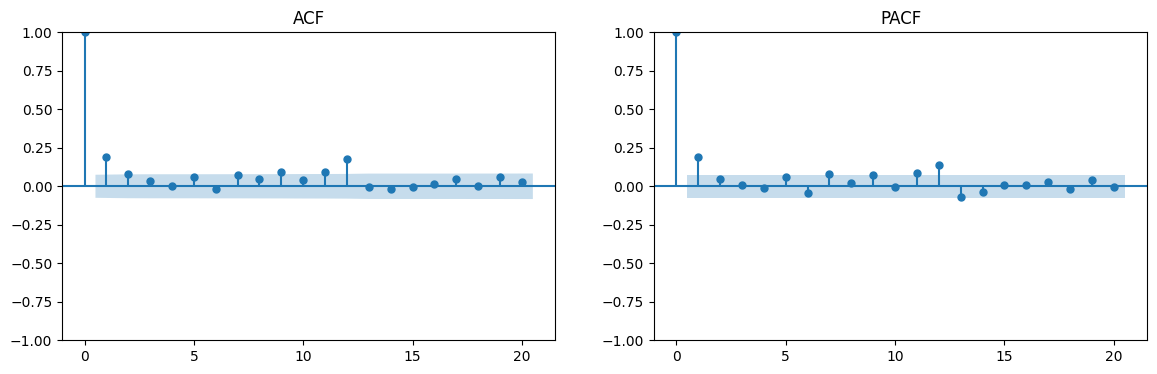

In [43]:
#ACF, PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

plot_acf(residuals, lags=20, ax=axes[0])
axes[0].set_title("ACF")

plot_pacf(residuals, lags=20, ax=axes[1], method="ywm")  # "ywm" ist stabil bei kurzen Reihen
axes[1].set_title("PACF")